# Boosting
##### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

from data import get_data

### Data Loading + Preprocessing

In [2]:
ROOT = './tadpole_challenge/'
X, y = get_data(ROOT)
label_dict = {0: 'AD', 1: 'CN', 2: 'EMCI', 3: 'LMCI', 4: 'SMC'}

##### Split data into Train and Test datasets

In [3]:
# create training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

### Helper Functions

In [4]:
# Source: https://stackoverflow.com/questions/55632010/using-scikit-learns-mlpclassifier-in-adaboostclassifier
class CustomMLPClassifier(MLPClassifier):
    def resample_with_replacement(self, X_train, y_train, sample_weight):

        # normalize sample_weights if not already
        sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

        X_train_resampled = np.zeros((len(X_train), len(X_train[0])), dtype=np.float32)
        y_train_resampled = np.zeros((len(y_train)), dtype=np.int)
        for i in range(len(X_train)):
            # draw a number from 0 to len(X_train)-1
            draw = np.random.choice(np.arange(len(X_train)), p=sample_weight)

            # place the X and y at the drawn number into the resampled X and y
            X_train_resampled[i] = X_train[draw]
            y_train_resampled[i] = y_train[draw]

        return X_train_resampled, y_train_resampled


    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            X, y = self.resample_with_replacement(X, y, sample_weight)
        return self._fit(X, y, incremental=(self.warm_start and
                                            hasattr(self, "classes_")))

In [5]:
def boosting_clf(clf):
    if (isinstance(clf,SVC)):
        return AdaBoostClassifier(base_estimator = clf, n_estimators = 100, random_state = 0, algorithm = 'SAMME', learning_rate = 0.1)
    else:
        return AdaBoostClassifier(base_estimator = clf, n_estimators = 100, random_state = 0, learning_rate = 0.1)

In [6]:
def accuracy(clf, X, y):
    y_pred = clf.predict(X)
    acc = sum(y_pred == y) / len(y)
    return acc

In [7]:
def showConfusionMatrix(clf, X, y):
    cm = confusion_matrix(y, clf.predict(X))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=('Predicted ' + label_dict[0], 'Predicted ' + label_dict[1], 'Predicted ' + label_dict[2], 'Predicted ' + label_dict[3], 'Predicted ' + label_dict[4]))
    ax.yaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=('Actual ' + label_dict[0], 'Actual ' + label_dict[1], 'Actual ' + label_dict[2], 'Actual ' + label_dict[3], 'Actual ' + label_dict[4]))

    for i in range(5):
        for j in range(5):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

In [8]:
def report_accuracy(clf):
    train_acc = accuracy(clf, X_train, y_train)
    test_acc = accuracy(clf, X_test, y_test)
    print('Train accuracy:', train_acc)
    print('Test accuracy:', test_acc)
    showConfusionMatrix(clf, X_test, y_test)

In [9]:
def evaluate(Classifier, **kwargs):
    print('+ Base learner')
    clf = Classifier(**kwargs).fit(X_train, y_train)
    report_accuracy(clf)
    print('+ Ensemble')
    boost_clf = boosting_clf(Classifier(**kwargs)).fit(X_train, y_train)
    report_accuracy(boost_clf)

In [10]:
def main():
    baselearners = [DecisionTreeClassifier, 
                    SVC, 
                    CustomMLPClassifier,
                    LogisticRegression]
    
    for learner in baselearners:
        print(learner)
        evaluate(learner)
        print()

### Model Training

##### Decision Tree

+ Base learner
Train accuracy: 1.0
Test accuracy: 0.6878612716763006


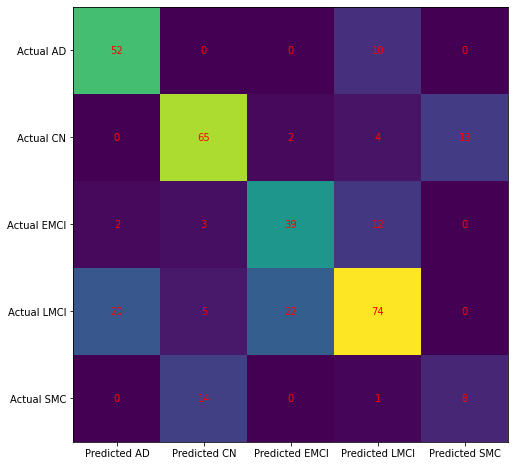

+ Ensemble
Train accuracy: 1.0
Test accuracy: 0.6936416184971098


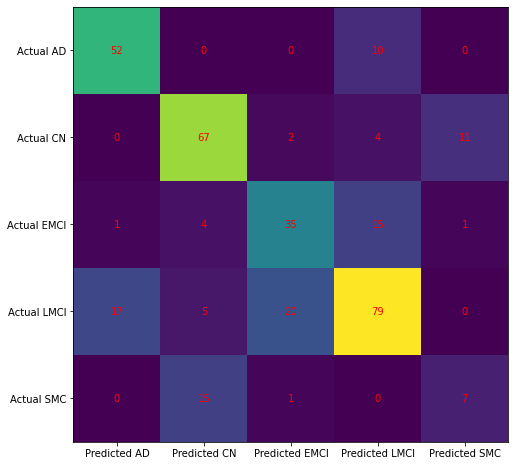

In [11]:
evaluate(DecisionTreeClassifier)

##### Logistic Regression Analysis (LRA)

+ Base learner
Train accuracy: 0.7044797687861272
Test accuracy: 0.7601156069364162


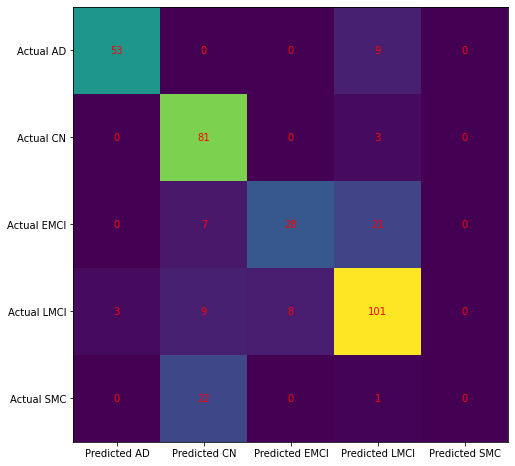

+ Ensemble
Train accuracy: 0.3453757225433526
Test accuracy: 0.3786127167630058


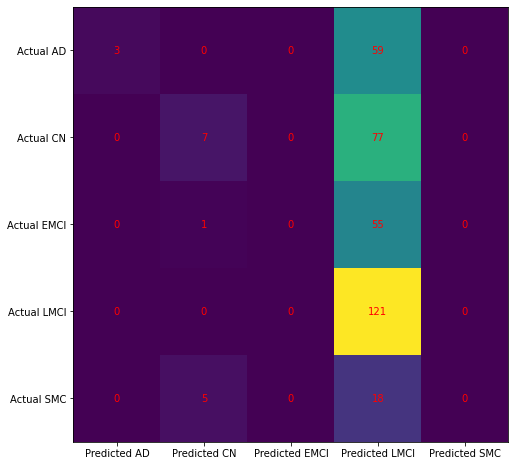

In [12]:
evaluate(LogisticRegression)

##### Artifical Neural Network (ANN)

+ Base learner
Train accuracy: 0.7738439306358381
Test accuracy: 0.7543352601156069


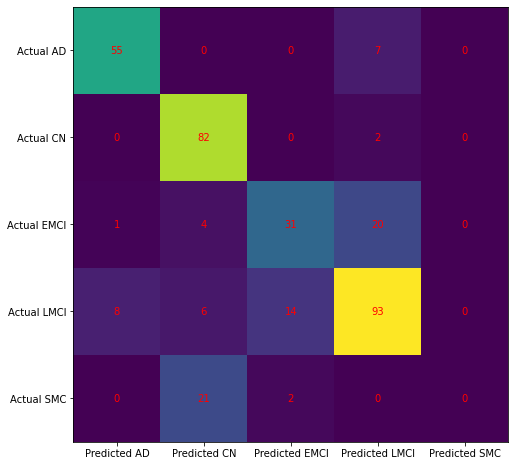

+ Ensemble
Train accuracy: 0.7015895953757225
Test accuracy: 0.6271676300578035


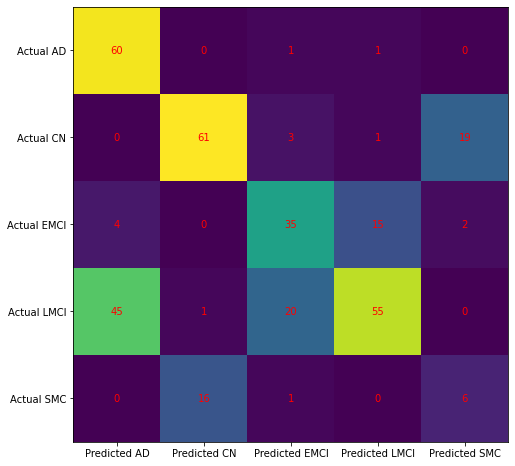

In [13]:
evaluate(CustomMLPClassifier)

##### SVM

+ Base learner
Train accuracy: 0.7651734104046243
Test accuracy: 0.7485549132947977


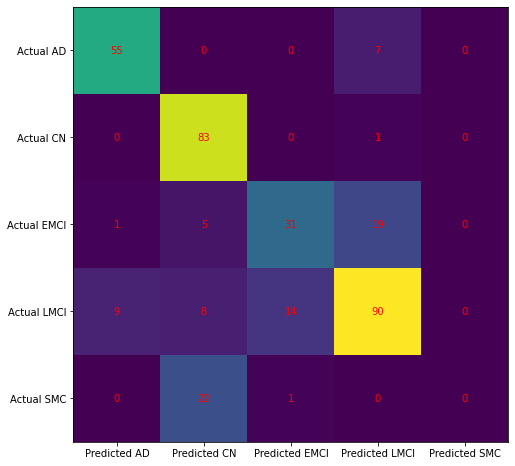

+ Ensemble
Train accuracy: 0.3179190751445087
Test accuracy: 0.34971098265895956


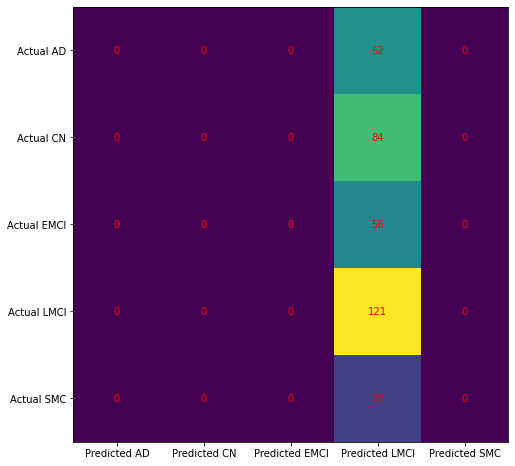

In [14]:
evaluate(SVC)

##### All base learners at once

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
+ Base learner
Train accuracy: 1.0
Test accuracy: 0.6907514450867052


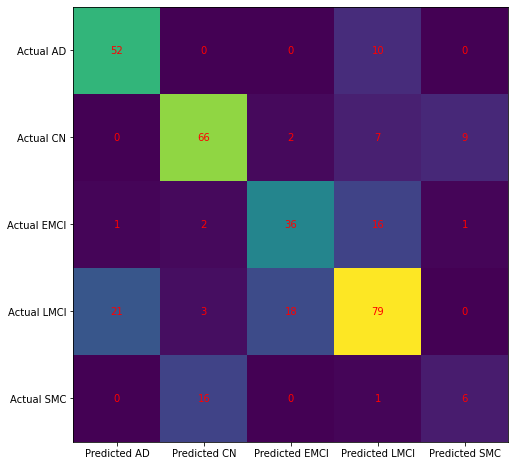

+ Ensemble
Train accuracy: 1.0
Test accuracy: 0.6936416184971098


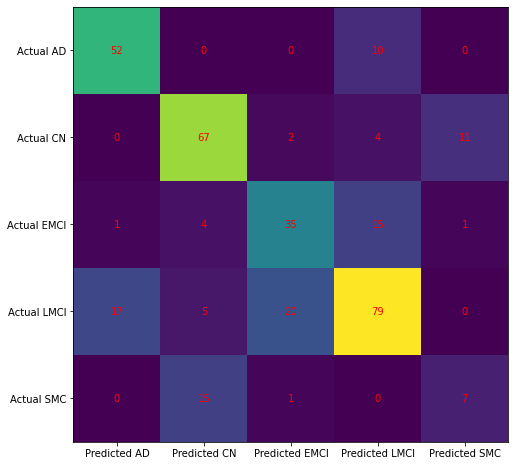


<class 'sklearn.svm._classes.SVC'>
+ Base learner
Train accuracy: 0.7651734104046243
Test accuracy: 0.7485549132947977


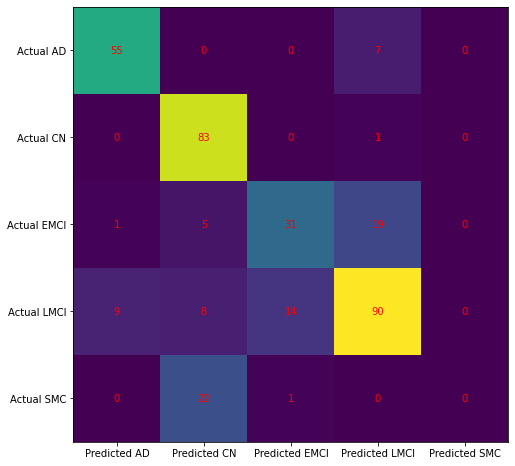

+ Ensemble
Train accuracy: 0.3179190751445087
Test accuracy: 0.34971098265895956


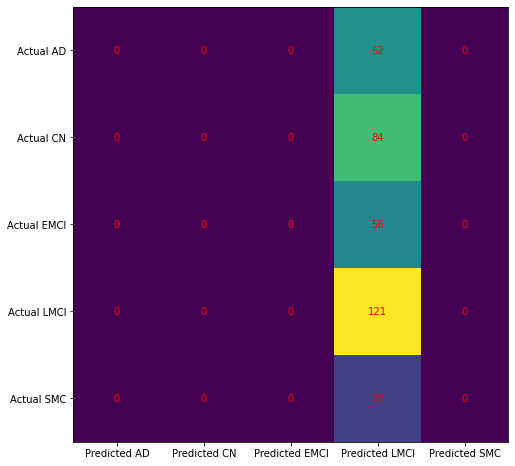


<class '__main__.CustomMLPClassifier'>
+ Base learner
Train accuracy: 0.7716763005780347
Test accuracy: 0.7572254335260116


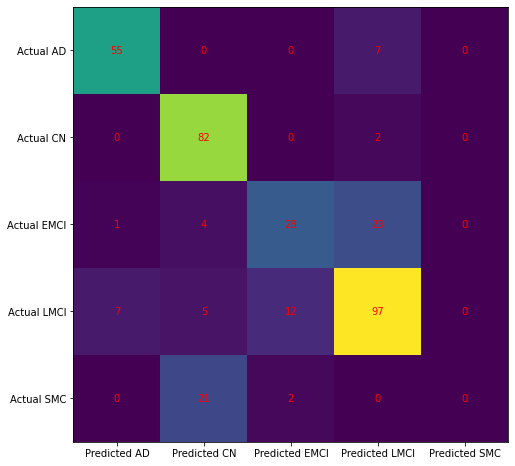

+ Ensemble
Train accuracy: 0.6950867052023122
Test accuracy: 0.6184971098265896


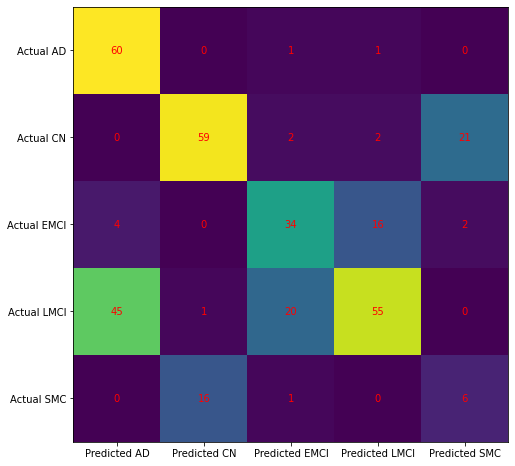


<class 'sklearn.linear_model._logistic.LogisticRegression'>
+ Base learner
Train accuracy: 0.7044797687861272
Test accuracy: 0.7601156069364162


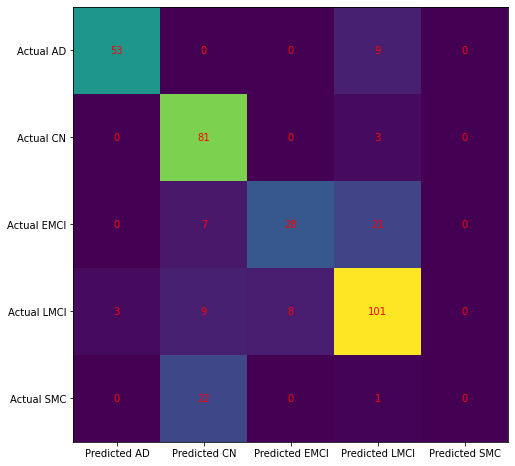

+ Ensemble
Train accuracy: 0.3453757225433526
Test accuracy: 0.3786127167630058


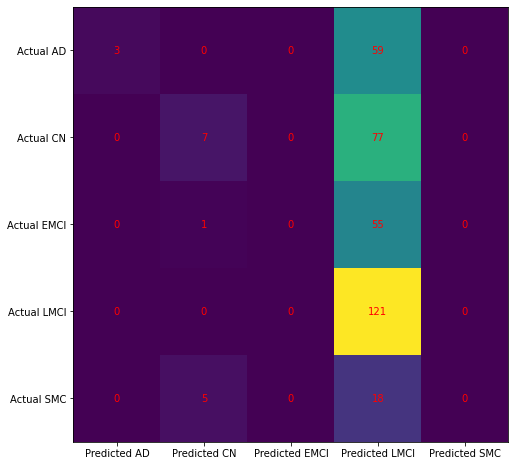

In [15]:
main()

### Experiment
Repeat 100 times